In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import tifffile
from skimage.color import rgb2gray
from skimage import measure
import napari
from apoc import ObjectSegmenter, ObjectClassifier
import pyclesperanto_prototype as cle  # version 0.24.1
import numpy as np
import napari_segment_blobs_and_things_with_membranes as nsbatwm  # version 0.3.6

In [8]:
# Define the directory containing your files
directory_path = Path("./data/2X z-stacks/Full_plate")

# Initialize a dictionary to store the grouped (per well) files
images_per_well = {}

# Iterate through the files in the directory
for file_path in directory_path.glob('*.TIF'):
    # Get the filename without the extension
    filename = file_path.stem
    
    # Extract the last part of the filename (e.g., A06f00d0)
    last_part = filename.split('_')[-1]
    
    # Get the first three letters to create the group name (well_id)
    well_id = last_part[:3]
    
    # Check if the well_id exists in the dictionary, if not, create a new list
    if well_id not in images_per_well:
        images_per_well[well_id] = []
    
    # Append the file to the corresponding group
    images_per_well[well_id].append(str(file_path))

In [9]:
# This is just a check, it prints the grouped z-stacks
for well_id, files in images_per_well.items():
    print(f'Well {well_id}:')
    for file_path in files:
        print(file_path)

Well A01:
data\2X z-stacks\Full_plate\D6_auto_Plate_M_p00_z00_0_A01f00d0.TIF
data\2X z-stacks\Full_plate\D6_auto_Plate_M_p00_z01_0_A01f00d0.TIF
data\2X z-stacks\Full_plate\D6_auto_Plate_M_p00_z02_0_A01f00d0.TIF
data\2X z-stacks\Full_plate\D6_auto_Plate_M_p00_z03_0_A01f00d0.TIF
data\2X z-stacks\Full_plate\D6_auto_Plate_M_p00_z04_0_A01f00d0.TIF
data\2X z-stacks\Full_plate\D6_auto_Plate_M_p00_z05_0_A01f00d0.TIF
data\2X z-stacks\Full_plate\D6_auto_Plate_M_p00_z06_0_A01f00d0.TIF
data\2X z-stacks\Full_plate\D6_auto_Plate_M_p00_z07_0_A01f00d0.TIF
data\2X z-stacks\Full_plate\D6_auto_Plate_M_p00_z08_0_A01f00d0.TIF
data\2X z-stacks\Full_plate\D6_auto_Plate_M_p00_z09_0_A01f00d0.TIF
data\2X z-stacks\Full_plate\D6_auto_Plate_M_p00_z10_0_A01f00d0.TIF
Well A02:
data\2X z-stacks\Full_plate\D6_auto_Plate_M_p00_z00_0_A02f00d0.TIF
data\2X z-stacks\Full_plate\D6_auto_Plate_M_p00_z01_0_A02f00d0.TIF
data\2X z-stacks\Full_plate\D6_auto_Plate_M_p00_z02_0_A02f00d0.TIF
data\2X z-stacks\Full_plate\D6_auto_Plate_

In [10]:
# Load one RGB image and transform it into grayscale for APOC
rgb_img = tifffile.imread(images_per_well["C04"][5], is_ome = False)
img = rgb2gray(rgb_img)
viewer = napari.Viewer(ndisplay=2)
viewer.add_image(img, name="Greyscale organoids")

<Image layer 'Greyscale organoids' at 0x1ebd312e520>

In [11]:
# Apply object segmenter from APOC
segmenter = ObjectSegmenter(opencl_filename="./ObjectSegmenter.cl")
result = segmenter.predict(image=img)
viewer.add_labels(result, name="Pre-processed organoid labels")

<Labels layer 'Pre-processed organoid labels' at 0x1ebeee98760>

In [12]:
# Closing some holes in the organoid labels
closed_labels = cle.closing_labels(result, None, radius=4.0)
# closed_labels = np.array(closed_labels, dtype=np.int32) # Change dtype of closed labels to feed array into nsbatwm.split
viewer.add_labels(closed_labels, name='Closed organoid labels (clesperanto)')

<Labels layer 'Closed organoid labels (clesperanto)' at 0x1ebf2836ca0>

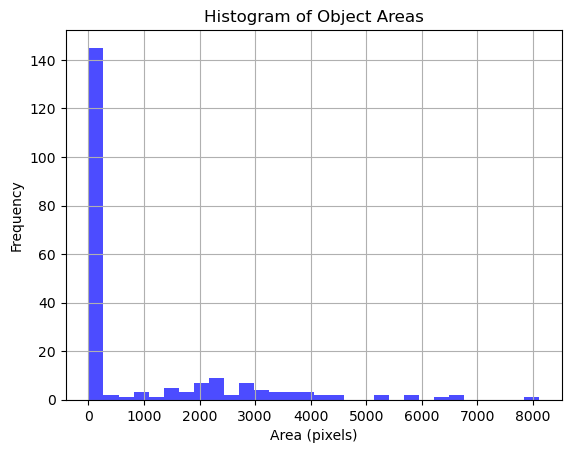

In [13]:
# Calculate and plot the area of each object to select a threshold to remove small objects
# and keep just the organoids
props = measure.regionprops(closed_labels) # Calculate the area of each labeled object

# Extract area values
area_values = [prop.area for prop in props]

# Create and display the histogram
plt.hist(area_values, bins=30, color='b', alpha=0.7)
plt.xlabel('Area (pixels)')
plt.ylabel('Frequency')
plt.title('Histogram of Object Areas')
plt.grid(True)
plt.show()

In [14]:
# Exclude small labels, cutout in pixel area seems to be below 1000px
exclude_small = cle.exclude_small_labels(closed_labels, None, 1000.0)
exclude_small = np.array(exclude_small, dtype=np.int32) # Change dtype of closed labels to feed array into nsbatwm.split
viewer.add_labels(exclude_small, name='Excluded small labels (clesperanto)')


<Labels layer 'Excluded small labels (clesperanto)' at 0x1b4ba8aa820>

In [15]:
# Splitting organoids into a binary mask
split_organoids = nsbatwm.split_touching_objects(exclude_small, sigma=10.0)
viewer.add_labels(split_organoids, name='Splitted touching organoids (nsbatwm)')

<Labels layer 'Splitted touching organoids (nsbatwm)' at 0x1b4adcec7c0>

In [16]:
# Connected component (cc) labeling
cc_split_organoids = nsbatwm.connected_component_labeling(split_organoids, False)
viewer.add_labels(cc_split_organoids, name='Connected component organoids (scikit-image, nsbatwm)')

<Labels layer 'Connected component organoids (scikit-image, nsbatwm)' at 0x1b4addaf940>

In [17]:
# Apply object classifier from APOC
classifier = ObjectClassifier(opencl_filename="./ObjectClassifier.cl")
result = classifier.predict(labels=cc_split_organoids, image=img)
viewer.add_labels(result, name="Focus and out of focus organoids")


<Labels layer 'Focus and out of focus organoids' at 0x1b4adb31310>

In [ ]:
# Convert the resulting .cle image into a np.array to count objects within each class

image_array = np.array(result, dtype=np.int8)
# Create masks for each class
background_mask = image_array == 0
out_of_focus_mask = image_array == 1
in_focus_mask = image_array == 2

# Label connected components in each mask
background_labels = measure.label(background_mask, connectivity=2)
out_of_focus_labels = measure.label(out_of_focus_mask, connectivity=2)
in_focus_labels = measure.label(in_focus_mask, connectivity=2)

# Calculate the number of objects in each class
num_background_objects = np.max(background_labels)
num_out_of_focus_objects = np.max(out_of_focus_labels)
num_in_focus_objects = np.max(in_focus_labels)

print(f"Number of Background Objects: {num_background_objects}")
print(f"Number of Out-of-Focus Objects: {num_out_of_focus_objects}")
print(f"Number of In-Focus Objects: {num_in_focus_objects}")